In [3]:
# Custom class to load, preprocess and transform the image and captions from flickr30k dataset
import random
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from datasets import load_dataset

class Flickr30kDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.dataset = self._prepare_data(split)
        self.transform = transform

    @staticmethod
    def _prepare_data(split):
        if split not in ("train", "val", "test"):
            raise ValueError(f"split must be either 'train', 'val' or 'test'. Given {split}")

        dataset = load_dataset("nlphuji/flickr30k")["test"]
        dataset = dataset.remove_columns(["sentids", "img_id", "filename"])
        return dataset.filter(lambda example: example["split"] == split)


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        captions = item['caption']
        caption = random.choice(captions)

        if self.transform:
            image = self.transform(image)

        return image, caption

# Image transformations for MobileNetV2 trained on imagenet-1k
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = Flickr30kDataset(split='train', transform=transform)
val_dataset = Flickr30kDataset(split='val', transform=transform)
test_dataset = Flickr30kDataset(split='test', transform=transform)


In [2]:
# custom function to create the flickr dashboard to visulaize the dataset
from pathlib import Path
import fiftyone as fo

def create_filckr32k_dashboard(split, max_samples=25, with_predictions=False, top_k=5, top_k_indices=None):
    fo_dataset = fo.Dataset(f"flickr30k-{split}", overwrite=True)
    samples = []
    raw_dataset = Flickr30kDataset(split=split, transform=None)
    save_path = f"./{split}_images"
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)
    for i, (image, caption) in enumerate(raw_dataset):
        image = image.convert("RGB")
        filepath = str(save_path / f"{i}.png")
        image.save(filepath)
        sample = fo.Sample(filepath=filepath)
        sample["ground_truth"] = fo.Classification(label=caption)
        if with_predictions:
            assert top_k_indices is not None
            for idx in range(top_k):
                matching_caption_idx = top_k_indices[i][idx].item()
                if matching_caption_idx < len(raw_dataset):
                    _, matching_caption = raw_dataset[matching_caption_idx]
                else:
                    # Handle the case where index is out of bounds (e.g., skip or assign a default value)
                    pass
                sample[f"predictions_{idx}"] = fo.Classification(label=matching_caption)

        samples.append(sample)

        if i > max_samples: break

    fo_dataset.add_samples(samples)
    return fo_dataset

fo_train_dataset = create_filckr32k_dashboard(split="train")

 100% |███████████████████| 27/27 [16.3ms elapsed, 0s remaining, 1.7K samples/s]      


In [ ]:
# launches the fiftyone dashboard for the flickr dataset
fosess = fo.launch_app(fo_train_dataset)

In [8]:
fosess.close()

In [4]:
# pre-trained sentence encoder model to embed captions
import torch
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('Snowflake/snowflake-arctic-embed-m')
text_model = AutoModel.from_pretrained('Snowflake/snowflake-arctic-embed-m', add_pooling_layer=False)
text_model.eval()

def text_embeddings(texts):
    tokens = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        query_embeddings = text_model(**tokens)[0][:, 0]

    normalized = F.normalize(query_embeddings, p=2, dim=1)
    return normalized

In [5]:
# pre-trained image-feature extractor model
import torch
import torch.nn.functional as F
from transformers import MobileNetV2ForImageClassification

image_model = MobileNetV2ForImageClassification.from_pretrained(
    "google/mobilenet_v2_1.0_224"
)
image_model.eval()
def image_embeddings(images):
    with torch.no_grad():
        image_logits = image_model(images).logits

    normalized = F.normalize(image_logits, p=2, dim=1)
    return normalized

In [16]:
# custom class for training the multimodal model
import torch
import torch.nn as nn

class CustomMultiModalModel(nn.Module):
    def __init__(self, text_embedding_dim=768, image_embedding_dim=1001, common_dim=64):
        super().__init__()
        self.text_transform = nn.Sequential(
            nn.Linear(text_embedding_dim, common_dim),
            nn.ReLU()
        )
        self.image_transform = nn.Sequential(
            nn.Linear(image_embedding_dim, common_dim),
            nn.ReLU()
        )
        self.final = nn.Linear(common_dim, common_dim)

    def forward(self, image_embeddings, text_embeddings):
        transformed_image = self.image_transform(image_embeddings)
        transformed_text = self.text_transform(text_embeddings)
        project_image = self.final(transformed_image)
        project_text = self.final(transformed_text)
        return project_image, project_text

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=2)

    def forward(self, image_features, text_features):
        logits = self.cosine_similarity(image_features.unsqueeze(0), text_features.unsqueeze(1)) / self.temperature
        batch_size = text_features.shape[0]
        # Labels are the main diagonal, as corresponding text and images are aligned
        labels = torch.arange(batch_size).to(logits.device)
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss

In [14]:
# testing the text embedding output
dummy_texts = ["This is a test caption.", "Another caption for testing."]
text_embeddings_output = text_embeddings(dummy_texts)

# Print the output to check
print("Text Embeddings Output Shape:", text_embeddings_output.shape)
print("Text Embeddings:", text_embeddings_output)

Text Embeddings Output Shape: torch.Size([2, 768])
Text Embeddings: tensor([[-0.0370,  0.0244,  0.0149,  ..., -0.0118,  0.0169,  0.0369],
        [-0.0428,  0.0270,  0.0198,  ..., -0.0094,  0.0170,  0.0356]])


In [46]:
%%time

import os
from torch.utils.data import DataLoader

os.environ["TOKENIZERS_PARALLELISM"] = "0"

lr = 3e-4
epochs = 5
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = CustomMultiModalModel()
loss_fn = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []

for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []
    for image_batch, text_batch in train_loader:
        image_features = image_embeddings(image_batch)
        text_features = text_embeddings(text_batch)
        optimizer.zero_grad()
        image_out, text_out = model(image_features, text_features)
        train_loss = loss_fn(image_out, text_out)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        print(f"Epoch {epoch}, Loss: {train_loss.item()}")

    average_train_loss = sum(train_losses) / len(train_losses)
    train_loss_history.append(average_train_loss)
    print(f"Epoch {epoch}, Average train loss: {average_train_loss}")

    torch.save(model.state_dict(), f"custom_multimodal_model_epoch_{epoch}.pt")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for image_batch, text_batch in val_loader:
            image_features = image_embeddings(image_batch)
            text_features = text_embeddings(text_batch)
            image_out, text_out = model(image_features, text_features)
            val_loss = loss_fn(image_out, text_out)
            val_losses.append(val_loss.item())

    average_val_loss = sum(val_losses) / len(val_losses)
    val_loss_history.append(average_val_loss)
    print(f"Epoch {epoch}, Average validation loss: {average_val_loss}")
    print("=" * 80)

Epoch 1, Loss: 4.15903902053833
Epoch 1, Loss: 4.159238815307617
Epoch 1, Loss: 4.158048152923584
Epoch 1, Loss: 4.156717300415039
Epoch 1, Loss: 4.157098770141602
Epoch 1, Loss: 4.156225204467773
Epoch 1, Loss: 4.15144157409668
Epoch 1, Loss: 4.156837463378906
Epoch 1, Loss: 4.154129981994629
Epoch 1, Loss: 4.148738861083984
Epoch 1, Loss: 4.146319389343262
Epoch 1, Loss: 4.145384311676025
Epoch 1, Loss: 4.1391191482543945
Epoch 1, Loss: 4.1477580070495605
Epoch 1, Loss: 4.1351542472839355
Epoch 1, Loss: 4.137333869934082
Epoch 1, Loss: 4.1281514167785645
Epoch 1, Loss: 4.128556728363037
Epoch 1, Loss: 4.110927581787109
Epoch 1, Loss: 4.108607769012451
Epoch 1, Loss: 4.10860013961792
Epoch 1, Loss: 4.079965591430664
Epoch 1, Loss: 4.071536064147949
Epoch 1, Loss: 4.06583309173584
Epoch 1, Loss: 4.0788044929504395
Epoch 1, Loss: 4.040790557861328
Epoch 1, Loss: 4.0539398193359375
Epoch 1, Loss: 4.036355972290039
Epoch 1, Loss: 3.993206739425659
Epoch 1, Loss: 3.982816457748413
Epoch 1,

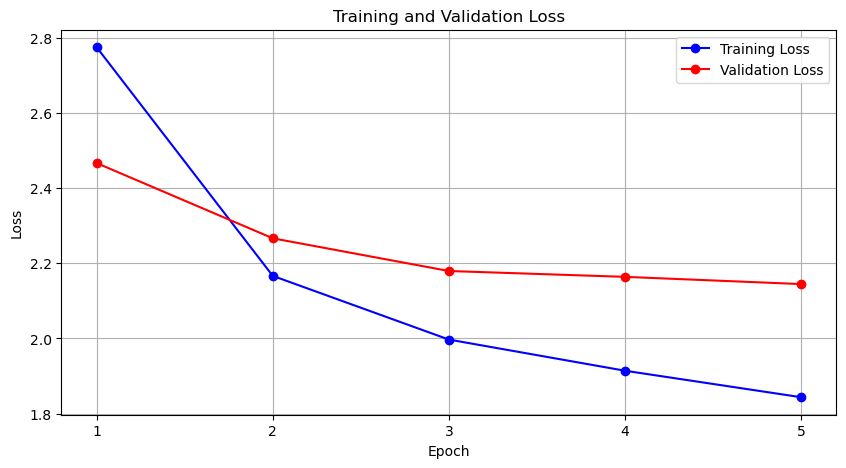

In [47]:
import matplotlib.pyplot as plt

plot_epochs = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(10, 5))
plt.plot(plot_epochs, train_loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(plot_epochs, val_loss_history, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(plot_epochs)
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# inference with the multimodal model
from torch.utils.data import DataLoader
all_image_embeddings = []
all_text_embeddings = []
batch_size = 64
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model = CustomMultiModalModel()
model.load_state_dict(torch.load("custom_multimodal_model_epoch_5.pt"))
model.eval()
for image, caption in test_loader:
    image_feature_embeddings = image_embeddings(image)
    text_feature_embeddings= text_embeddings(caption)
    projected_image_emb, projected_text_emb = model(image_feature_embeddings, text_feature_embeddings)
    # print("printing image emb shape",projected_image_emb.shape)
    # print("printing text emb shape", projected_text_emb.shape)
    all_image_embeddings.append(projected_image_emb)
    all_text_embeddings.append(projected_text_emb)

assert len(all_image_embeddings) == len(all_text_embeddings)


In [18]:
all_image_embeddings = torch.cat(all_image_embeddings, dim = 0)
all_image_embeddings.shape

torch.Size([1014, 64])

In [19]:
all_text_embeddings = torch.cat(all_text_embeddings, dim = 0)
all_text_embeddings.shape

torch.Size([1014, 64])

In [20]:
%%time

import torch.nn.functional as F
cosine_similarities = F.cosine_similarity(all_image_embeddings.unsqueeze(1), all_text_embeddings.unsqueeze(0), dim=2)

k = 5
top_k_values, top_k_indices = torch.topk(cosine_similarities, k=k, dim=1)
print(top_k_indices)
print(len(top_k_indices))

tensor([[781, 596, 252, 795, 275],
        [259, 315, 421,  35,   8],
        [590, 842, 695, 594, 304],
        ...,
        [400, 329, 750, 632, 413],
        [788, 233, 538,  36,  17],
        [779, 560, 644, 538, 901]])
1014
CPU times: user 118 ms, sys: 225 ms, total: 343 ms
Wall time: 128 ms


In [21]:
cosine_similarities.shape

torch.Size([1014, 1014])

In [ ]:
# run the top_K prediction on test dataset and visualize the result on the dashboard
%%time

fo_test_dataset = create_filckr32k_dashboard(split="test", with_predictions=True, top_k=k, top_k_indices=top_k_indices)


In [96]:
# visualize the result on the dashboard
fosess = fo.launch_app(fo_test_dataset)